# Steering and lighting notebook
This notebook will create some buttons and visualize the output signals.
The first thing we do is add some imports.

In [1]:
from __future__ import annotations

import asyncio
import os
from enum import Enum, auto
from typing import Dict

import ipywidgets as ipw
from IPython.core.display_functions import DisplayHandle
from PIL import Image
from remotivelabs.broker import BrokerClient, RestbusSignalConfig, Signal
from remotivelabs.topology.control import ControlClient, ControlRequest

## Creating a Virtual Interface
We create a virtual interface in order to update input signals on other ECUs. We do this in functions which we will later tie to input buttons.

In [2]:
url = os.environ.get("REMOTIVE_BROKER_URL", "http://topology-broker.com:50051")

c = await BrokerClient(url=url).connect()


def turn_stalk(x: str):
    asyncio.get_event_loop().create_task(
        c.restbus.update_signals(
            (
                "SCCM-DriverCan0",
                [
                    RestbusSignalConfig.set(name="TurnStalk.TurnSignal", value={"Left": 1, "Off": 0, "Right": 2}[x]),
                ],
            )
        )
    )


def light_stalk(x: str):
    asyncio.get_event_loop().create_task(
        c.restbus.update_signals(
            (
                "SCCM-DriverCan0",
                [
                    RestbusSignalConfig.set(name="LightStalk.LightMode", value={"Off": 0, "Daylight Running lights": 1, "Low Beam": 2}[x]),
                ],
            )
        )
    )


def high_beams(x: str):
    asyncio.get_event_loop().create_task(
        c.restbus.update_signals(
            (
                "SCCM-DriverCan0",
                [
                    RestbusSignalConfig.set(name="LightStalk.HighBeam", value={"Off": 0, "On": 1}[x]),
                ],
            )
        )
    )


def hazard_light(x: str):  # noqa: ARG001
    """Toggle hazard button on every click, to simulate how steering wheel behaves"""
    asyncio.get_event_loop().create_task(
        c.restbus.update_signals(
            (
                "SCCM-DriverCan0",
                [
                    RestbusSignalConfig(name="HazardLightButton.HazardLightButton", loop=[0], initial=[1]),
                ],
            )
        )
    )


def brake(x: int):
    asyncio.get_event_loop().create_task(
        c.restbus.update_signals(
            (
                "SCCM-DriverCan0",
                [
                    RestbusSignalConfig.set(name="BrakePedalPositionSensor.BrakePedalPosition", value=x),
                ],
            )
        )
    )


def steering_angle(x: int):
    asyncio.get_event_loop().create_task(
        c.restbus.update_signals(
            (
                "SCCM-DriverCan0",
                [
                    RestbusSignalConfig.set(name="SteeringAngle.SteeringAngle", value=x),
                ],
            )
        )
    )


def set_operating_mode(mode):
    """custom control message to restart the FMU"""

    async def _update():
        async with ControlClient(client=c) as cc:
            request = ControlRequest(type="emergency_mode", argument=mode)
            await cc.send(target_ecu="BCM", request=request)

    asyncio.get_event_loop().create_task(_update())

## Creating a car
We create a simple car with some images in order to visualize the output signals

In [3]:
class LightState(Enum):
    OFF = 0.0
    ON = 1.0


class Lights(Enum):
    FRONT_LEFT = auto()
    FRONT_RIGHT = auto()
    REAR_LEFT = auto()
    REAR_RIGHT = auto()


class MyCar:
    def __init__(self):
        on = Image.open("images/car-lights-on.png")
        off = Image.open("images/car-lights-off.png")
        if on.size != off.size:
            raise Exception("images are not of same size")
        w, h = on.size
        on = on.resize((h // 5, w // 5))
        off = off.resize((h // 5, w // 5))
        self.size = on.size
        h, w = self.size
        half_h = h // 2
        half_w = w // 2
        self._lights: Dict[Lights, Dict[LightState, Image.Image]] = {
            Lights.REAR_RIGHT: {LightState.OFF: off.crop((0, 0, half_w, h)), LightState.ON: on.crop((0, 0, half_w, h))},
            Lights.REAR_LEFT: {LightState.OFF: off.crop((half_w, 0, w, half_h)), LightState.ON: on.crop((half_w, 0, w, half_h))},
            Lights.FRONT_RIGHT: {LightState.OFF: off.crop((0, half_h, half_w, h)), LightState.ON: on.crop((0, half_h, half_w, h))},
            Lights.FRONT_LEFT: {LightState.OFF: off.crop((half_w, half_h, w, h)), LightState.ON: on.crop((half_w, half_h, w, h))},
        }
        self.lights: Dict[Lights, Image.Image] = {
            Lights.REAR_RIGHT: self._lights[Lights.REAR_RIGHT][LightState.OFF],
            Lights.REAR_LEFT: self._lights[Lights.REAR_LEFT][LightState.OFF],
            Lights.FRONT_RIGHT: self._lights[Lights.FRONT_RIGHT][LightState.OFF],
            Lights.FRONT_LEFT: self._lights[Lights.FRONT_LEFT][LightState.OFF],
        }
        self._display = DisplayHandle()
        self.img = Image.new("RGB", (w, h))
        self._display.display(self.img)
        self.img.paste(self.lights[Lights.FRONT_LEFT], (w // 2, h // 2))
        self.img.paste(self.lights[Lights.FRONT_RIGHT], (0, h // 2))
        self.img.paste(self.lights[Lights.REAR_LEFT], (w // 2, 0))
        self.img.paste(self.lights[Lights.REAR_RIGHT], (0, 0))
        self._display.update(self.img)

    async def on_front_left(self, signal: Signal) -> None:
        w, h = self.size
        self.lights[Lights.FRONT_LEFT] = self._lights[Lights.FRONT_LEFT][LightState(signal.value)]
        self.img.paste(self.lights[Lights.FRONT_LEFT], (w // 2, h // 2))
        self._display.update(self.img)

    async def on_front_right(self, signal: Signal) -> None:
        _, h = self.size
        self.lights[Lights.FRONT_RIGHT] = self._lights[Lights.FRONT_RIGHT][LightState(signal.value)]
        self.img.paste(self.lights[Lights.FRONT_RIGHT], (0, h // 2))
        self._display.update(self.img)

    async def on_rear_left(self, signal: Signal) -> None:
        w, _ = self.size
        self.lights[Lights.REAR_LEFT] = self._lights[Lights.REAR_LEFT][LightState(signal.value)]
        self.img.paste(self.lights[Lights.REAR_LEFT], (w // 2, 0))
        self._display.update(self.img)

    async def on_rear_right(self, signal: Signal) -> None:
        self.lights[Lights.REAR_RIGHT] = self._lights[Lights.REAR_RIGHT][LightState(signal.value)]
        self.img.paste(self.lights[Lights.REAR_RIGHT], (0, 0))
        self._display.update(self.img)

## Hooking it up
We create buttons and sliders and tie them to the previous functions we created.

We start a simulation for the car and start the car visualization.

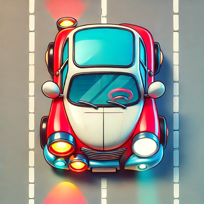

In [4]:
# toggle buttons
toggle_params = {"disabled": False, "button_style": "", "value": "Off"}

turn_stalk_buttons = ipw.ToggleButtons(options=["Left", "Off", "Right"], description="Turn stalk", **toggle_params)

light_stalk_buttons = ipw.ToggleButtons(options=["Off", "Daylight Running lights", "Low Beam"], description="Light stalk", **toggle_params)

high_beam_button = ipw.ToggleButtons(options=["Off", "On"], description="High beams", **toggle_params)

hazard_label = ipw.Label(value="Hazard")

hazard_button = ipw.Button(description="!", disabled=False, button_style="")

emergency_mode_button = ipw.Button(description="Emergency Mode", disabled=False, button_style="")

# sliders
slider_layout = {"continuous_update": True, "disabled": False, "readout": True, "readout_format": "d"}

brake_slider = ipw.IntSlider(min=0, max=255, description="Brake pedal", **slider_layout)

steering_slider = ipw.IntSlider(min=-440, max=440, description="Steering Wheel", **slider_layout)

# Create observers for the widgets
turn_stalk_buttons.observe(lambda change: turn_stalk(change["new"]), names="value")
light_stalk_buttons.observe(lambda change: light_stalk(change["new"]), names="value")
high_beam_button.observe(lambda change: high_beams(change["new"]), names="value")
brake_slider.observe(lambda change: brake(change["new"]), names="value")
steering_slider.observe(lambda change: steering_angle(change["new"]), names="value")
hazard_button.on_click(lambda _btn: hazard_light("new"))
emergency_mode_button.on_click(lambda _btn: set_operating_mode("emergency"))

# Create a layout with two rows
centered_layout = {
    "align_items": "center",
    "justify_content": "space-around",
}

top_box = ipw.VBox(
    [turn_stalk_buttons, light_stalk_buttons, high_beam_button, hazard_label, hazard_button, emergency_mode_button],
    layout=ipw.Layout(**centered_layout, width="80%", margin="10px"),
)

bottom_box = ipw.HBox([brake_slider, steering_slider], layout=ipw.Layout(**centered_layout, height="100px", width="80%"))

main_container = ipw.VBox(
    [top_box, bottom_box], layout=ipw.Layout(**centered_layout, width="800px", border="1px solid #ddd", padding="10px")
)

display(main_container)

# Create a car object and start the simulation
my_car = MyCar()
sub = await c.subscribe(
    ("FLCM-BodyCan0", ["TurnLightControl.LeftTurnLightRequest", "TurnLightControl.RightTurnLightRequest"]),
    ("RLCM-BodyCan0", ["TurnLightControl.LeftTurnLightRequest", "TurnLightControl.RightTurnLightRequest"]),
    on_change=True,
)
handlers = {
    ("FLCM-BodyCan0", "TurnLightControl.LeftTurnLightRequest"): my_car.on_front_left,
    ("FLCM-BodyCan0", "TurnLightControl.RightTurnLightRequest"): my_car.on_front_right,
    ("RLCM-BodyCan0", "TurnLightControl.LeftTurnLightRequest"): my_car.on_rear_left,
    ("RLCM-BodyCan0", "TurnLightControl.RightTurnLightRequest"): my_car.on_rear_right,
}


async def handle_signals(sub, handlers):
    async for signals in sub:
        for signal in signals:
            await handlers[(signal.namespace, signal.name)](signal)


sub_task = asyncio.create_task(handle_signals(sub, handlers))

## Teardown
Run this to stop everything

In [ ]:
sub_task.cancel()
await c.disconnect()